# Data Augmentation and Classification of CIFAR-10
---
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. So examples are given in the image below:

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

---
## Loading and Augmenting Data

Start by loading the training and test data using built-in pytorch modules. Then further split the training data into validation and test data. Augmenting data which is slightly rotated or flipped gives the CNN an opportunity to be more ROTATION AND TRANSLATION INVARIANT. (Positional variance in general)

#### Augmentation

In this cell, basic data augmentation is performed by randomly flipping and rotating the given image data. 

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


batch_size = 25
valid_size = 0.2

# converting data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Loading training and testing set from the CIFAR10 dataset
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# The image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

<ipython-input-8-2181f8df30a5>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


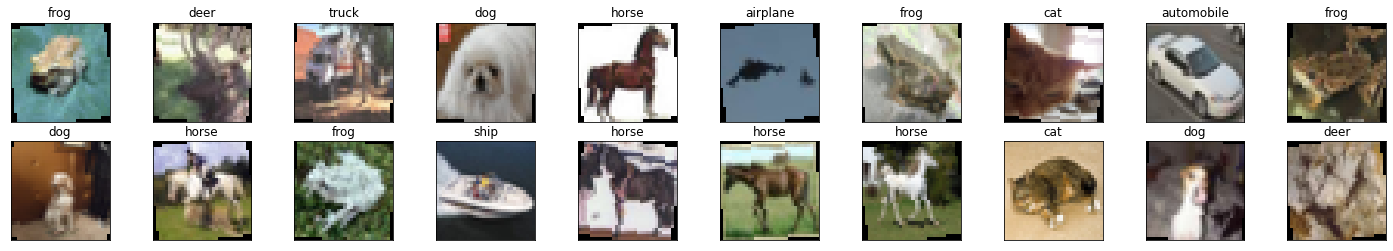

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [9]:
# Defining the CNN architecture for the 10-class classification task.

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500) #Hidden FC layer with 500 neurons
        self.fc2 = nn.Linear(500, 10) #Output layer with 10 neurons
        #Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.20)

    def forward(self, x):
        # Sequence of conv and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten for input to dense layers
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
import torch.optim as optim

# Since it's a multi-class classification problem, Categorical Cross Entropy loss would be a good option.
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient descent for training the parameters of the network.
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Training

In [11]:
# I used only 10 epochs to save time during the demo
n_epochs = 10

valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
   
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() #Clear residual gradients at every iteration.
        # forward pass
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # Model validation
  
    model.eval() # This ensures dropouts etc. are disabled. 
    for batch_idx, (data, target) in enumerate(valid_loader):
        # forward pass
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.3f} --> {:.3f}).'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.098 	Validation Loss: 1.838
Validation loss decreased (inf --> 1.838).
Epoch: 2 	Training Loss: 1.708 	Validation Loss: 1.572
Validation loss decreased (1.838 --> 1.572).
Epoch: 3 	Training Loss: 1.536 	Validation Loss: 1.462
Validation loss decreased (1.572 --> 1.462).
Epoch: 4 	Training Loss: 1.437 	Validation Loss: 1.370
Validation loss decreased (1.462 --> 1.370).
Epoch: 5 	Training Loss: 1.360 	Validation Loss: 1.296
Validation loss decreased (1.370 --> 1.296).
Epoch: 6 	Training Loss: 1.296 	Validation Loss: 1.216
Validation loss decreased (1.296 --> 1.216).
Epoch: 7 	Training Loss: 1.235 	Validation Loss: 1.194
Validation loss decreased (1.216 --> 1.194).
Epoch: 8 	Training Loss: 1.181 	Validation Loss: 1.127
Validation loss decreased (1.194 --> 1.127).
Epoch: 9 	Training Loss: 1.138 	Validation Loss: 1.097
Validation loss decreased (1.127 --> 1.097).
Epoch: 10 	Training Loss: 1.088 	Validation Loss: 1.035
Validation loss decreased (1.097 --> 1.035).


###  Load the Model with the Lowest Validation Loss

In [12]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

---
## Testing the trained model

In [13]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # forward pass
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.016986

Test Accuracy of airplane: 68% (682/1000)
Test Accuracy of automobile: 77% (779/1000)
Test Accuracy of  bird: 41% (411/1000)
Test Accuracy of   cat: 54% (549/1000)
Test Accuracy of  deer: 58% (580/1000)
Test Accuracy of   dog: 54% (541/1000)
Test Accuracy of  frog: 71% (713/1000)
Test Accuracy of horse: 71% (718/1000)
Test Accuracy of  ship: 76% (766/1000)
Test Accuracy of truck: 74% (741/1000)

Test Accuracy (Overall): 64% (6480/10000)
